# CAFEf6-regrid-zarr

**Date:** <br>
June 10 2022 <br>
**Background:** <br>
Issue - https://github.com/Thomas-Moore-Creative/NCI-CAFE-ARD/issues/2 <br>
**Author(s):**<br>
Thomas Moore<br>

### OOD documentation
https://opus.nci.org.au/display/DAE/Setting+up+a+Dask+Cluster+on+OOD

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## import helper

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("helper", "/g/data/v14/tm4888/code/helper-py/helper_tools.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

## OOD cluster

In [4]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='03:00:00')
client = Client(cluster)
cluster.scale(cores=24)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.136:39077,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


#### maintain attributes

In [6]:
xr.set_options(keep_attrs=True)

In [7]:
path_in = '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20151101/'
path_out = '/g/data/xv83/users/tm4888/data/CAFE/hindcast_f6/'

# load 2D T & Ugrid zarr

In [8]:
CAFEf6_Tgrid_2D = xr.open_zarr(path_out+'CAFEf6_Tgrid_2D.zarr',consolidated=True)

In [9]:
CAFEf6_Ugrid_2D = xr.open_zarr(path_out+'CAFEf6_Ugrid_2D.zarr',consolidated=True)

# rename coordinates

In [10]:
CAFEf6_Tgrid_2D = CAFEf6_Tgrid_2D.rename({'xt_ocean':'lon','yt_ocean':'lat'})
CAFEf6_Ugrid_2D = CAFEf6_Ugrid_2D.rename({'xu_ocean':'lon','yu_ocean':'lat'})

# shift longitude to 0 - 360

In [11]:
CAFEf6_Tgrid_2D = (CAFEf6_Tgrid_2D.assign_coords(lon=(CAFEf6_Tgrid_2D.lon % 360))).sortby('lon')

In [12]:
CAFEf6_Ugrid_2D = (CAFEf6_Ugrid_2D.assign_coords(lon=(CAFEf6_Ugrid_2D.lon % 360))).sortby('lon')

***

# Make 1.0 degree land mask
uses https://github.com/toddkarin/global-land-mask <br>
which is based on elevation data here > https://www.ngdc.noaa.gov/mgg/topo/gltiles.html

(longitude: 100) array[130.5, 131.5, 132.5, 133.5, 134.5, 135.5, 136.5, 137.5, 138.5, 139.5,
       140.5, 141.5, 142.5, 143.5, 144.5, 145.5, 146.5, 147.5, 148.5, 149.5,
       150.5, 151.5, 152.5, 153.5, 154.5, 155.5, 156.5, 157.5, 158.5, 159.5,
       160.5, 161.5, 162.5, 163.5, 164.5, 165.5, 166.5, 167.5, 168.5, 169.5,
       170.5, 171.5, 172.5, 173.5, 174.5, 175.5, 176.5, 177.5, 178.5, 179.5,
       180.5, 181.5, 182.5, 183.5, 184.5, 185.5, 186.5, 187.5, 188.5, 189.5,
       190.5, 191.5, 192.5, 193.5, 194.5, 195.5, 196.5, 197.5, 198.5, 199.5,
       200.5, 201.5, 202.5, 203.5, 204.5, 205.5, 206.5, 207.5, 208.5, 209.5,
       210.5, 211.5, 212.5, 213.5, 214.5, 215.5, 216.5, 217.5, 218.5, 219.5,
       220.5, 221.5, 222.5, 223.5, 224.5, 225.5, 226.5, 227.5, 228.5, 229.5])

(latitude: 90)>
array([-69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5])

In [13]:
from global_land_mask import globe

# Lat/lon points to get
lat = np.linspace(-89.5,89.5,180)
lon = np.linspace(-179.5,179.5,360)

# Make a grid
lon_grid, lat_grid = np.meshgrid(lon,lat)

# Get whether the points are on land.
z = globe.is_land(lat_grid, lon_grid)

In [14]:
land_mask = xr.DataArray(
   ...:     z,
   ...:     coords={
   ...:         "lat": lat,
   ...:         "lon": lon,
   ...:     },
   ...:     dims=["lat", "lon"],
   ...:     )

land_mask = land_mask.astype(int)
land_mask

<xarray.DataArray (lat: 180, lon: 360)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

(100.0, 180.0)

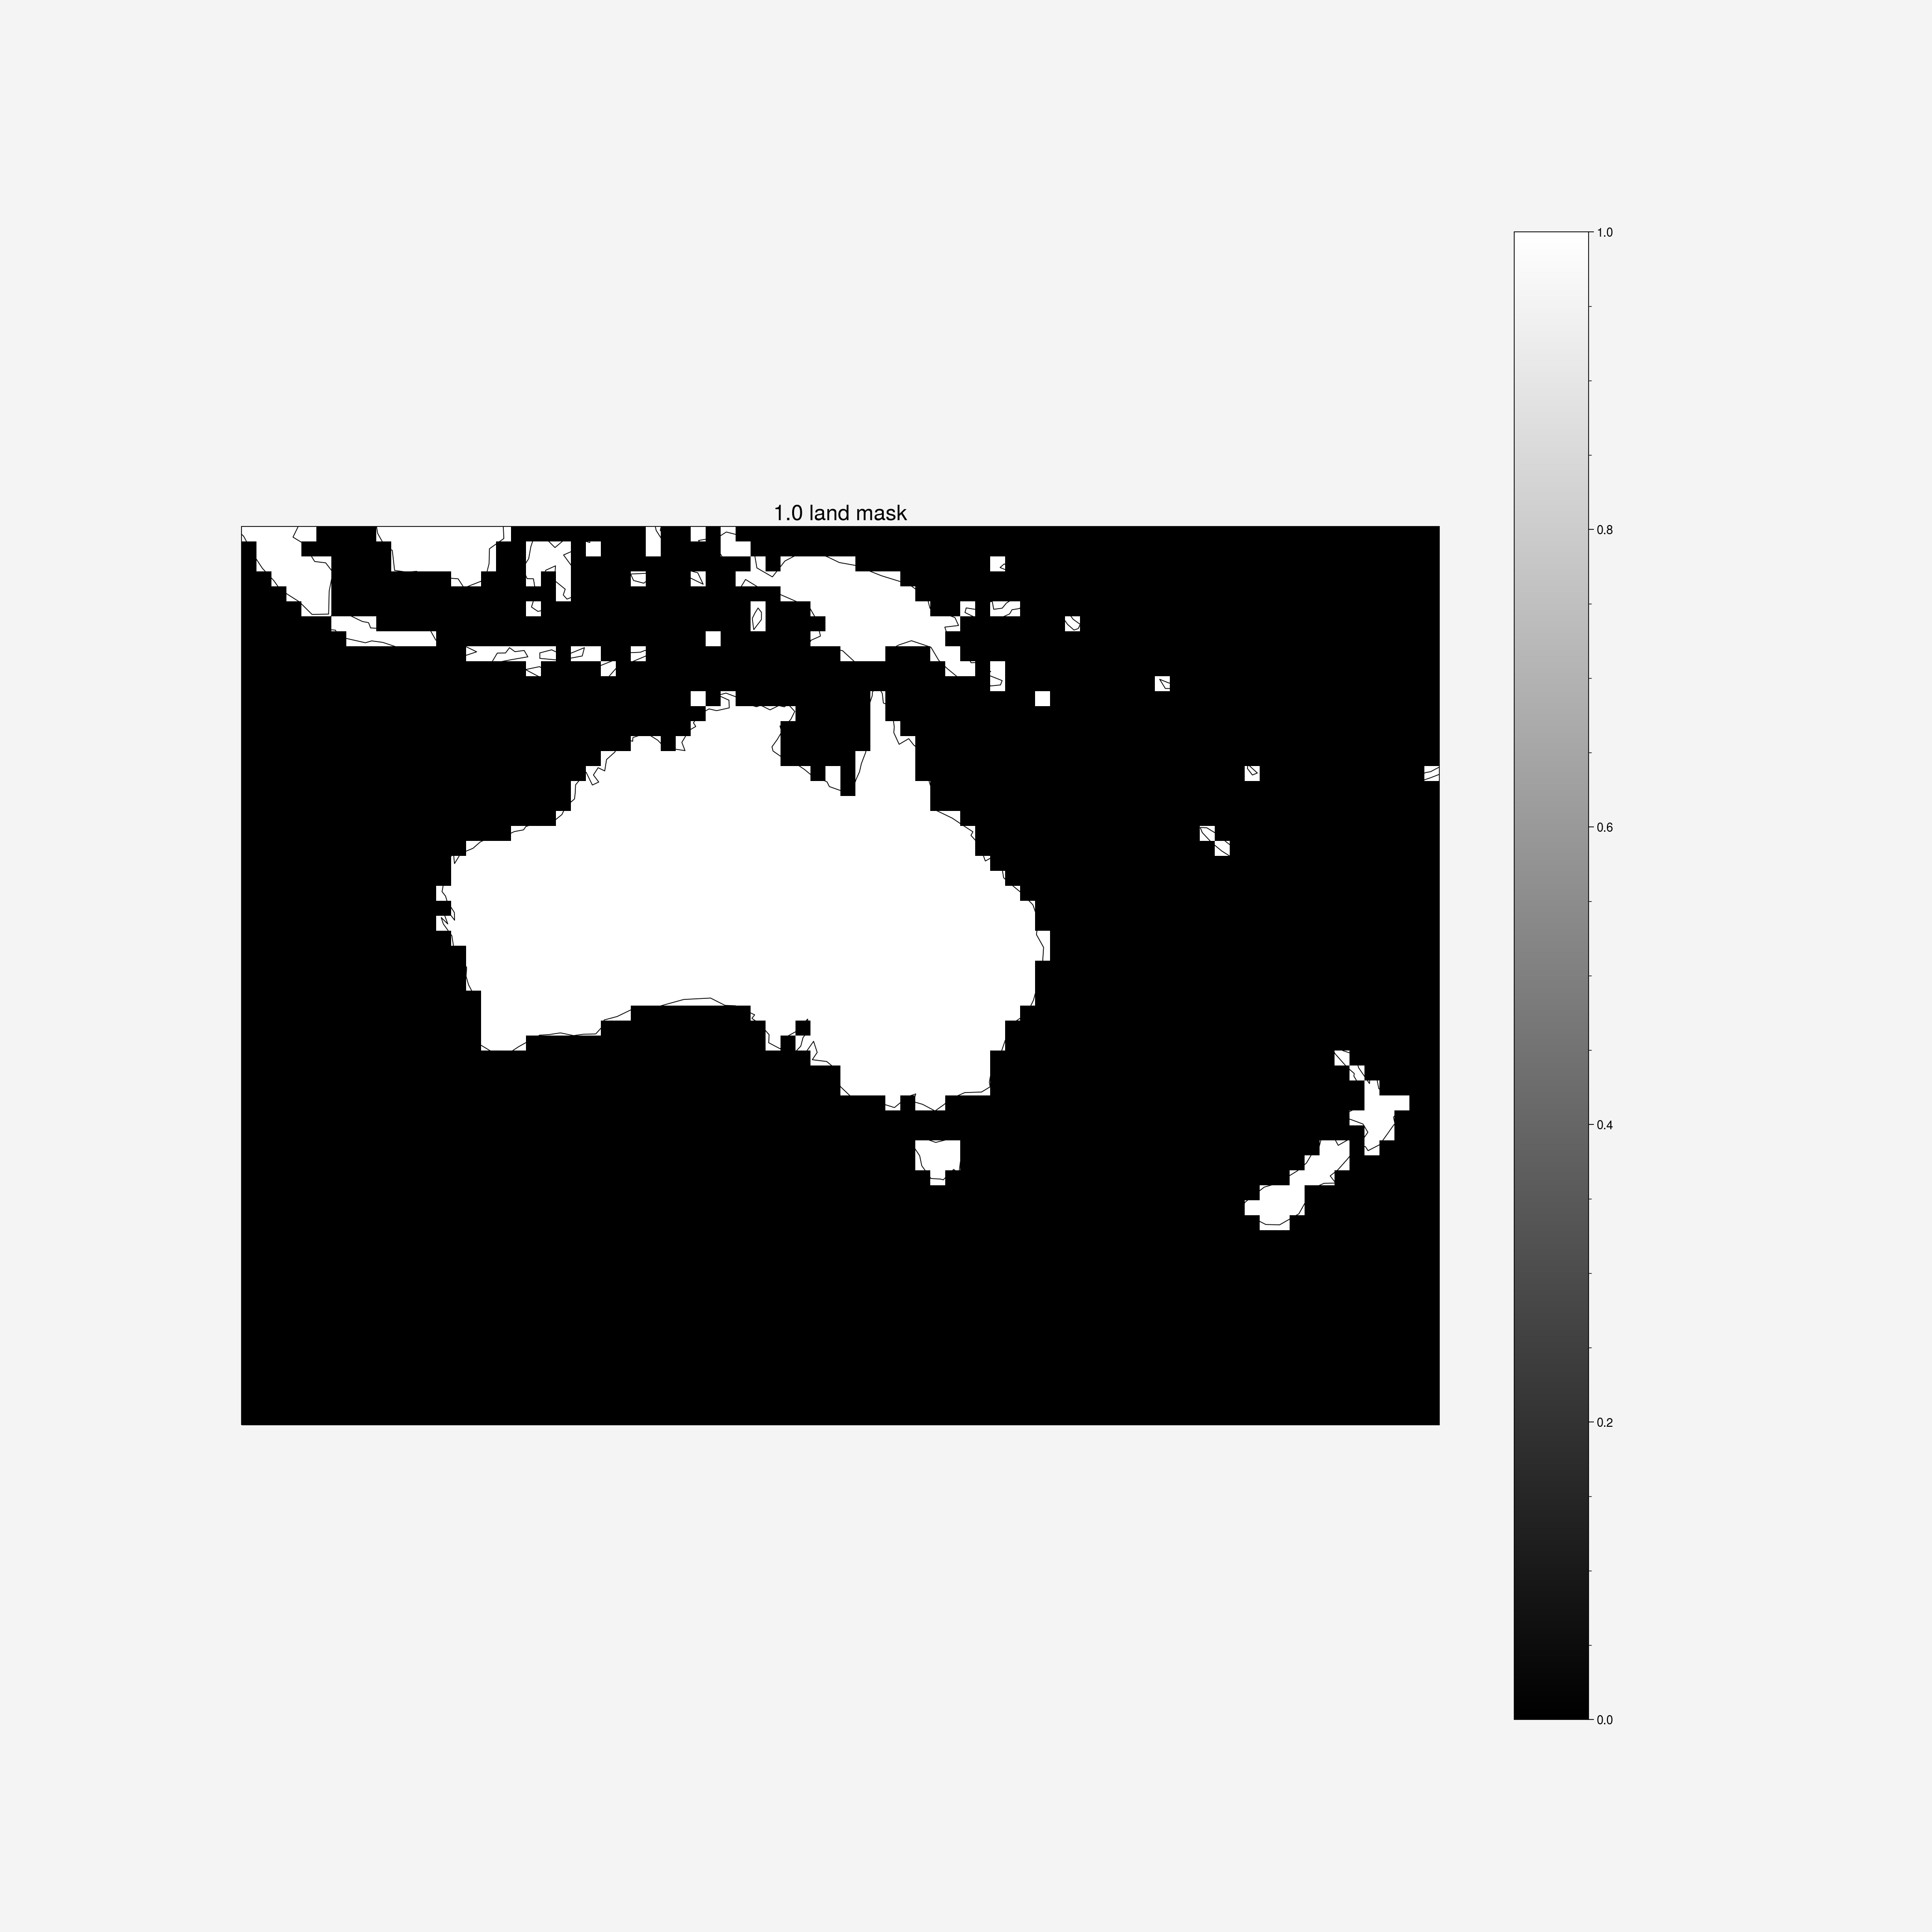

In [15]:
fig1 = plt.figure(figsize=(20,20),dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
land_mask.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), robust=False, add_colorbar=True, cmap = 'binary_r'
)
ax.set_title('1.0 land mask', fontsize=16)
ax.coastlines()
ax.set_ylim([-60, 0])
ax.set_xlim([100, 180])

# manhandle this array to shift across the dateline

In [16]:
land_mask_shifted = (land_mask.assign_coords(lon=(land_mask.lon % 360))).sortby('lon')

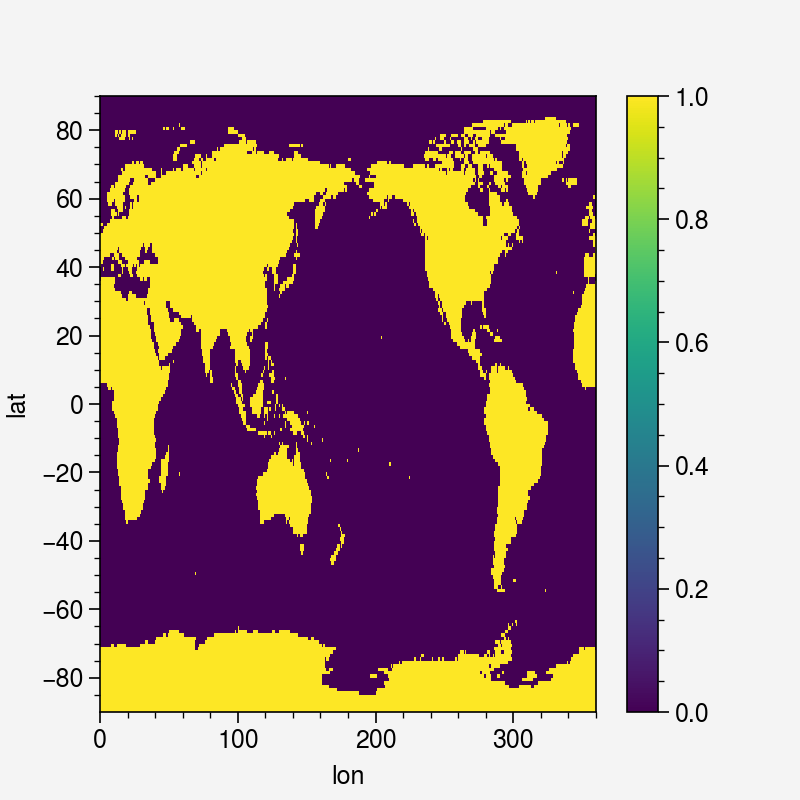

In [17]:
land_mask_shifted.plot()

In [18]:
output_mask = land_mask_shifted

# make land (1) Nans and zeros stay finite

In [19]:
output_mask = output_mask.where(output_mask < 1, drop = True)

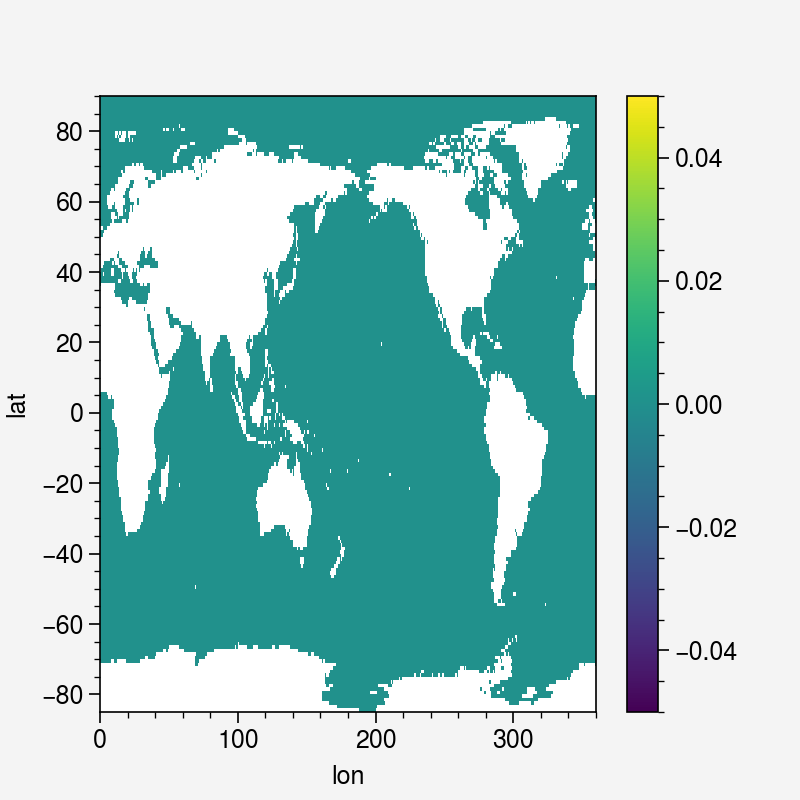

In [20]:
output_mask.plot()

# <hr>
# Tgrid - Regridding Step

#### make a new global WCPFC_1deg grid

In [21]:
WCPFC_lats = np.linspace(-89.5,89.5,num=180)
WCPFC_lons = np.linspace(0.5,359.5,num=360)
fake_grid_data = np.ones((360,180))

In [22]:
WCPFC_1deg_grid = xr.DataArray(fake_grid_data, coords=[WCPFC_lons,WCPFC_lats], dims=['lon','lat'])

In [23]:
WCPFC_1deg_grid

<xarray.DataArray (lon: 360, lat: 180)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

# add a "mask" variable to the input 

In [24]:
sst_for_mask = CAFEf6_Tgrid_2D.sst.isel(time=0)

In [25]:
CAFEf6_Tgrid_2D['mask'] = xr.where(np.isfinite(sst_for_mask), 1, 0)

# add a "mask" variable to the output 

In [26]:
WCPFC_1deg_grid['mask'] = xr.where(np.isfinite(output_mask), 1, 0)

# make Tgrid regridder - NOT using extrapolation here

In [27]:
%%time
#regridder_1deg_Tgrid = xe.Regridder(CAFE60_Tgrid_2D, WCPFC_1deg_grid, method='bilinear', extrap_method="nearest_s2d", reuse_weights=False)
regridder_1deg_Tgrid = xe.Regridder(CAFEf6_Tgrid_2D, WCPFC_1deg_grid, method='bilinear', reuse_weights=False)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


CPU times: user 5.89 s, sys: 1.1 s, total: 6.98 s
Wall time: 20.2 s


## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the dataset object

In [28]:
%%time
regridder_1deg_Tgrid._grid_in = None
regridder_1deg_Tgrid._grid_out = None
CAFEf6_1deg_Tgrid_2D = regridder_1deg_Tgrid(CAFEf6_Tgrid_2D)

CPU times: user 4.39 s, sys: 293 ms, total: 4.69 s
Wall time: 6.65 s


In [29]:
CAFEf6_1deg_Tgrid_2D = CAFEf6_1deg_Tgrid_2D.drop('mask')
CAFEf6_1deg_Tgrid_2D = CAFEf6_1deg_Tgrid_2D.where(CAFEf6_1deg_Tgrid_2D != 0)

### write this out given how many times we're needing to re-run this notebook

In [30]:
%%time
CAFEf6_1deg_Tgrid_2D.to_zarr(store = path_out+'CAFEf6_1deg_Tgrid_2D.zarr',consolidated=True)

CPU times: user 7 s, sys: 790 ms, total: 7.79 s
Wall time: 1min 16s


In [31]:
CAFEf6_1deg_Tgrid_2D = xr.open_zarr(path_out+'CAFEf6_1deg_Tgrid_2D.zarr',consolidated=True)

---

# U grid

### add mask

In [32]:
eke300_for_mask = CAFEf6_Ugrid_2D.eke300.isel(time=0)

In [33]:
CAFEf6_Ugrid_2D['mask'] = xr.where(np.isfinite(eke300_for_mask), 1, 0)

In [34]:
%%time
regridder_1deg_Ugrid = xe.Regridder(CAFEf6_Ugrid_2D, WCPFC_1deg_grid, method='bilinear', reuse_weights=False)
regridder_1deg_Ugrid._grid_in = None
regridder_1deg_Ugrid._grid_out = None
CAFEf6_1deg_Ugrid_2D = regridder_1deg_Ugrid(CAFEf6_Ugrid_2D)
CAFEf6_1deg_Ugrid_2D = CAFEf6_1deg_Ugrid_2D.drop('mask')

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


CPU times: user 3.54 s, sys: 50.9 ms, total: 3.59 s
Wall time: 3.83 s


# drop the zero's introduced by the masked bilinear

In [35]:
CAFEf6_1deg_Ugrid_2D = CAFEf6_1deg_Ugrid_2D.where(CAFEf6_1deg_Ugrid_2D != 0)

In [36]:
%%time
CAFEf6_1deg_Ugrid_2D.to_zarr(store = path_out+'CAFEf6_1deg_Ugrid_2D.zarr',consolidated=True)

CPU times: user 544 ms, sys: 98.9 ms, total: 643 ms
Wall time: 2.13 s


In [37]:
CAFEf6_1deg_Ugrid_2D = xr.open_zarr(path_out+'CAFEf6_1deg_Ugrid_2D.zarr',consolidated=True)

# Merge into one object on the new grid

In [38]:
CAFEf6_1deg = xr.merge([CAFEf6_1deg_Tgrid_2D,CAFEf6_1deg_Ugrid_2D])

In [39]:
CAFEf6_1deg

<xarray.Dataset>
Dimensions:     (time: 37, lat: 180, lon: 360)
Coordinates:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(37,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(37,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(37,), meta=np.ndarray>
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time        (time) object 2015-11-16 00:00:00 ... 2018-11-16 00:00:00
Data variables: (12/16)
    D20         (time, lat, lon) float64 dask.array<chunksize=(37, 180, 360), meta=np.ndarray>
    hc200       (time, lat, lon) float64 dask.array<chunksize=(37, 180, 360), meta=np.ndarray>
    hc300       (time, lat, lon) float64 dask.array<chunksize=(37, 180, 360), meta=np.ndarray>
    mld         (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    sss         (time, lat, lon) float32 dask.array<chunksize=(37, 180, 360), meta=np.ndarray>
    sst         (time, lat, lon) float32 dask.array<chunksize=(37, 180, 360), meta=np.ndarray>
    ...          ...
    eke2000     (time, lat, lon) float64 dask.array<chunksize=(37, 180, 360), meta=np.ndarray>
    eke300      (time, lat, lon) float64 dask.array<chunksize=(37, 180, 360), meta=np.ndarray>
    u100        (time, lat, lon) float32 dask.array<chunksize=(37, 180, 360), meta=np.ndarray>
    u100_300    (time, lat, lon) float64 dask.array<chunksize=(37, 180, 360), meta=np.ndarray>
    v100        (time, lat, lon) float32 dask.array<chunksize=(37, 180, 360), meta=np.ndarray>
    v100_300    (time, lat, lon) float64 dask.array<chunksize=(37, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Write out object to `zarr` collection

In [40]:
%%time
CAFEf6_1deg.to_zarr(store = path_out+'CAFEf6_1deg_ETBFvar.zarr',consolidated=True)

CPU times: user 762 ms, sys: 140 ms, total: 902 ms
Wall time: 2.02 s


# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [ ]:
client.restart()

In [41]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [ ]:
client.restart()